# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

# Exercise Solution

Choosen first possibility, so i parallelized my code with *continent* solution.

As metric was used the euclidean distance, as using this formula:

$$
    D = \sum_{i=0}^{N} \sqrt{\left(x[i + 1] - x[i]\right)^2 + \left(y[i + 1] - y[i]\right)^2}
$$

Where $N$ identifies the number of cities, in this context Periodic Boundary Conditions (PBC) where applyed, and those are denoted by `[]` operator, so that $N+1=0$.
Another metric that could be used is the Greater Circle Distance, this can be certainly better, because due to size of Italy (lenght = 1200 km, [source](https://it.wikipedia.org/wiki/Geografia_dell%27Italia#Punti_estremi)), this is comparable to Earth Radius (6370 km, [source](https://en.wikipedia.org/wiki/Earth_radius)),
but in this context was not deemed necessary.
In the code a distance matrix was calculated by the first process (rank = 0) and then communicated to other processes, to reduce the number of calculation during optimization phase. For this purpose [Armadillo Library](https://arma.sourceforge.net/) was used.

The subsequent char used was taken from [ISTAT Archive](https://www.istat.it/it/archivio/222527).

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import geopandas

plt.style.use('seaborn-v0_8')

In [12]:
italy: geopandas.GeoDataFrame = geopandas.read_file(
    "eser_10/results/ProvCM01012024_g_WGS84.shp"
).to_crs('EPSG:4326')
data = pd.read_csv("eser_10/results/best_route.csv")
data.loc[data.shape[0]] = data.iloc[0]
data.tail()

,INDEX,PROVINCE,LONGITUDE,LATITUDE
106,61,Nuoro,9.34238,40.1277
107,96,Ogliastra,9.66781,39.9705
108,97,Trapani,12.51600,38.0174
109,65,Palermo,13.35240,38.1112
110,0,Agrigento,13.57470,37.3123


In [27]:
cities = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data['LONGITUDE'], data['LATITUDE']), crs="EPSG:4326")
cities


,INDEX,PROVINCE,LONGITUDE,LATITUDE,geometry
0,0,Agrigento,13.57470,37.3123,POINT (13.57470 37.31230)
1,19,Caltanissetta,14.06320,37.4899,POINT (14.06320 37.48990)
2,31,Enna,14.28070,37.5668,POINT (14.28070 37.56680)
3,77,Ragusa,14.72130,36.9220,POINT (14.72130 36.92200)
4,90,Siracusa,15.29070,37.0646,POINT (15.29070 37.06460)
...,...,...,...,...,...
106,61,Nuoro,9.34238,40.1277,POINT (9.34238 40.12770)
107,96,Ogliastra,9.66781,39.9705,POINT (9.66781 39.97050)
108,97,Trapani,12.51600,38.0174,POINT (12.51600 38.01740)
109,65,Palermo,13.35240,38.1112,POINT (13.35240 38.11120)


/home/pilo/miniconda3/envs/SimNumeric/lib/python3.10/site-packages/geopandas/plotting.py:397: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


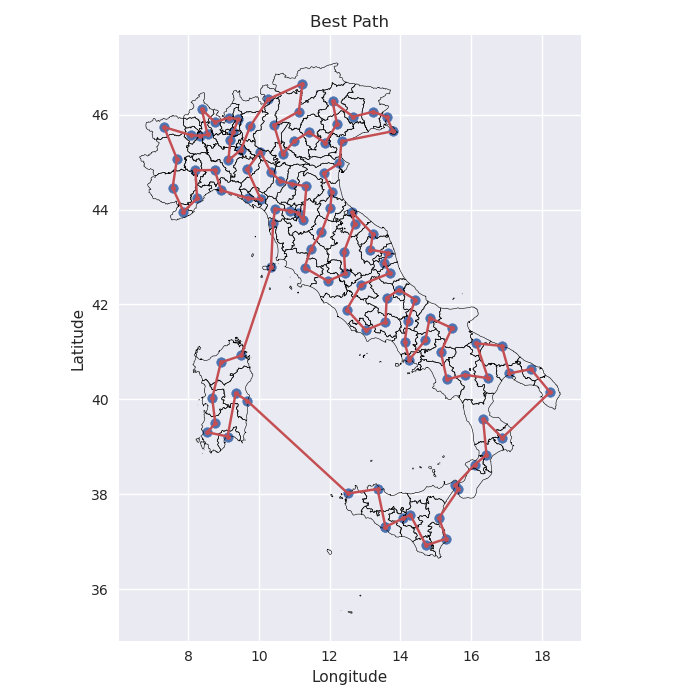

In [30]:
ax = italy.boundary.plot(edgecolor='k', linewidth=0.4)
cities.plot(ax =ax)


plt.gcf().set_size_inches(7,7)
plt.plot(data['LONGITUDE'], data['LATITUDE'], c='C2', marker = '.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Best Path')
plt.tight_layout()